# Trainer API를 활용한 Fine Tuning 하기.

### 1. Load package and set environment variable.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import sys
from omegaconf import OmegaConf

from sklearn.metrics import accuracy_score, f1_score

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    EvalPrediction,
    Trainer,
    TrainingArguments,
)
from transformers.integrations import WandbCallback

sys.path.append('/root/nlp-with-transformers')
from src.data import EmotionDataModule

/opt/conda/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


* 평가지표 정의하기
    * Trainer 내부에서 사용할 `compute_metrics`을 정의함.
    * 모델 학습 과정에서 `EvalPrediction`객체 (has attribute predictions, label_ids)를 전달받아서 평가지표 계산이 가능함.

In [3]:
def compute_metrics(pred:EvalPrediction):
    """Get EvalPrediction and Calculate the metrics"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1":f1}

### 2. Prepare Train

* configuration은 크게 data, model, training쪽을 구분함.

In [4]:
config = OmegaConf.load('conf/ft.yaml')

In [5]:
os.environ['WANDB_PROJECT'] = config.env['wandb']['WANDB_PROJECT']

* load datamodule

In [6]:
tokenizer = AutoTokenizer.from_pretrained(config.model.pretrained_model_name_or_path)
dm = EmotionDataModule(tokenizer=tokenizer, **OmegaConf.to_container(config.data))
dm.setup()

No config specified, defaulting to: emotion/split
No config specified, defaulting to: emotion/split
Found cached dataset emotion (/root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-805eceb002e5c82e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-e72b1f240cb76b39.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-363a00d3f7a34dfe.arrow


* 사전학습된 모델 로드

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(
    config.model.pretrained_model_name_or_path, 
    num_labels=dm.num_classes
).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

* 다른 arguments에 의존성이 있는 training args를 정의 및 trainer 실행.

In [8]:
model_base_dir = '/root/model_safari'
config.training.output_dir = f"{model_base_dir}/{config.model.pretrained_model_name_or_path}-finetuned-emotion"
config.training.logging_steps = len(dm.ds['train']) // config.training.per_device_train_batch_size
training_args = TrainingArguments(**OmegaConf.to_container(config.training))

In [9]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dm.ds['train'],
                  eval_dataset=dm.ds['validation'],
                  data_collator=dm.get_collate_fn(),
                  callbacks=[WandbCallback()]
                 )

### 3. Train model and error analysis

In [10]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: datalama. Use `wandb login --relogin` to force relogin


[2023-01-28 14:12:11.489: W smdistributed/modelparallel/torch/nn/predefined_hooks.py:75] Found unsupported HuggingFace version 4.25.1 for automated tensor parallelism. HuggingFace modules will not be automatically distributed. You can use smp.tp_register_with_module API to register desired modules for tensor parallelism, or directly instantiate an smp.nn.DistributedModule. Supported HuggingFace transformers versions for automated tensor parallelism: ['4.17.0', '4.20.1', '4.21.0']
[2023-01-28 14:12:11.614 ee7736cf838b:6163 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-28 14:12:11.813 ee7736cf838b:6163 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.806500,0.297971,0.907500,0.905532
2,0.223800,0.179479,0.926500,0.926736
3,0.153000,0.167645,0.930500,0.930748


TrainOutput(global_step=750, training_loss=0.39442213948567706, metrics={'train_runtime': 170.4522, 'train_samples_per_second': 281.604, 'train_steps_per_second': 4.4, 'total_flos': 1078278745731840.0, 'train_loss': 0.39442213948567706, 'epoch': 3.0})

* predicts를 통해 예측값을 받을 수 있음.

In [11]:
predicts = trainer.predict(dm.ds['validation'])
predicts

PredictionOutput(predictions=array([[ 5.342431  , -0.748187  , -0.9119474 , -1.3511102 , -0.98249835,
        -2.0106544 ],
       [ 5.388138  , -0.9198535 , -1.6204123 , -0.839222  , -0.6345675 ,
        -2.0176485 ],
       [-1.1927006 ,  2.7087789 ,  3.3186982 , -1.2060337 , -2.2849152 ,
        -1.7351953 ],
       ...,
       [-1.2495072 ,  5.467493  ,  0.02851418, -1.1384978 , -1.6312011 ,
        -1.3859411 ],
       [-1.7930529 ,  3.4082494 ,  2.8959336 , -1.3615875 , -2.3405159 ,
        -1.4781576 ],
       [-1.7234824 ,  5.1620793 , -0.18463172, -1.6443827 , -1.7053567 ,
        -0.34447598]], dtype=float32), label_ids=array([0, 0, 2, ..., 1, 1, 1]), metrics={'test_loss': 0.16764523088932037, 'test_accuracy': 0.9305, 'test_f1': 0.9307476278484202, 'test_runtime': 1.9593, 'test_samples_per_second': 1020.764, 'test_steps_per_second': 16.332})

* 오차 행렬

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [13]:
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion matrix")
    plt.show()

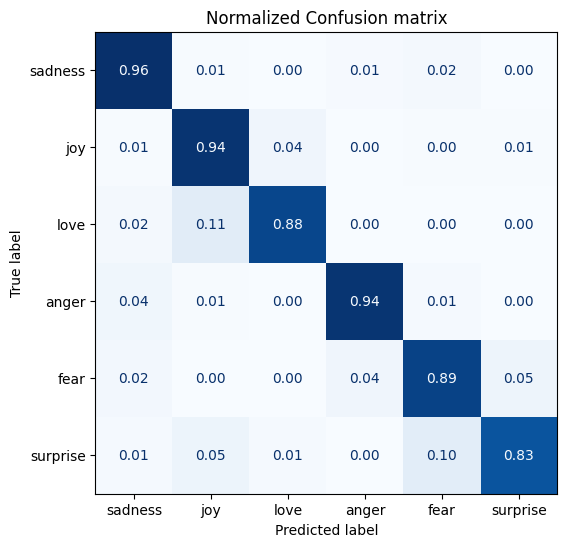

In [14]:
import numpy as np
y_preds = np.argmax(predicts.predictions, axis=1)
plot_confusion_matrix(y_preds, dm.ds['validation']['label'], dm.id2label)

* error analysis
  * 모델의 validation loss가 큰 순으로 정렬하는 것. (가장 심플)

In [15]:
from torch.nn.functional import cross_entropy
vl_dl = trainer.get_eval_dataloader(dm.ds['validation'])
bs = vl_dl.batch_size
vl_loss_dict = {k:list() for k in ["text", "label", "predicted_label", "loss"]}

In [16]:
for i, batch in enumerate(vl_dl):
    vl_loss_dict['text'] += dm.ds['validation']['text'][i*bs:(i+1)*bs]
    vl_loss_dict['label'] += dm.ds['validation']['label'][i*bs:(i+1)*bs].numpy().tolist()
    inputs = {k:v.to(device) for k,v in batch.items()}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["labels"].to(device), 
                             reduction="none")
        
    vl_loss_dict['loss'] += loss.cpu().numpy().tolist()
    vl_loss_dict['predicted_label'] += pred_label.cpu().numpy().tolist()


In [17]:
import pandas as pd
vl_loss_df = pd.DataFrame.from_dict(vl_loss_dict)

In [18]:
vl_loss_df['label'] =vl_loss_df['label'].apply(lambda x:dm.id2label[x])
vl_loss_df['predicted_label'] = vl_loss_df['predicted_label'].apply(lambda x:dm.id2label[x])

* to hedge low-confidence 

In [19]:
vl_loss_df.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.074354
882,i feel badly about reneging on my commitment t...,love,sadness,5.546005
1963,i called myself pro life and voted for perry w...,joy,sadness,5.529081
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.459432
1840,id let you kill it now but as a matter of fact...,joy,fear,5.244661
1111,im lazy my characters fall into categories of ...,joy,fear,5.217749
1274,i am going to several holiday parties and i ca...,joy,sadness,4.703819
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.633213
1950,i as representative of everything thats wrong ...,surprise,sadness,4.474708
1590,deception from a person i loved very much,anger,love,4.028261


* to hedge over-confidence

In [20]:
vl_loss_df.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
1310,i feel like an ungrateful asshole,sadness,sadness,0.006002
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.006098
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.006102
69,i have no extra money im worried all of the ti...,sadness,sadness,0.006104
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.006143
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.006188
189,i leave the meeting feeling more than a little...,sadness,sadness,0.006197
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.006200
1303,i feel pathetic and uninspired,sadness,sadness,0.006211
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.006222


Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/conda/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


---

* trainer의 callback에 붙어있는 wandb